In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.8 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


In [3]:
# can not process by batch: no enough RAM memory
def extract_embedding(ukrainian_sentences):

  # Tokenize all sentences and convert them to input IDs
  tokenized_inputs = tokenizer(ukrainian_sentences, padding=True, truncation=True, return_tensors="pt")

  # Pass the input IDs through the model to get embeddings
  with torch.no_grad():
      outputs = model(**tokenized_inputs)

  # Extract embeddings from the output
  embeddings = outputs.last_hidden_state.mean(dim=1)  # Average the embeddings over all tokens

  return list(embeddings)

from sklearn.metrics.pairwise import cosine_similarity
def calculate_text_similarity(embedding1, embedding2):
    # Reshape the embeddings to be 1D arrays
    embedding1 = embedding1.reshape(1, -1)
    embedding2 = embedding2.reshape(1, -1)

    # Calculate the cosine similarity using NumPy
    similarity = cosine_similarity(embedding1, embedding2)

    return similarity[0, 0]

def process(df):
  # extract embedding from summary
  summary_sentences = df['summary'].tolist()
  df['summary_embeddings'] = extract_embedding(summary_sentences)

  # extract embedding from topic
  topic_sentences = list(df['predicted_class'].unique())
  topic_embeddings = extract_embedding(topic_sentences)
  topic_embedding_map = dict(map(lambda i,j : (i,j) , topic_sentences, topic_embeddings))
  df['topic_embeddings'] = df['predicted_class'].apply(lambda x: topic_embedding_map[x])

  # calculate text similariy
  df['coverage_rate'] = df[['summary_embeddings', 'topic_embeddings']].apply(lambda x: calculate_text_similarity(x['summary_embeddings'], x['topic_embeddings']), axis=1)
  return df

In [4]:
# process by rows
def extract_embedding(ukrainian_sentences):

  # Tokenize all sentences and convert them to input IDs
  tokenized_inputs = tokenizer(ukrainian_sentences, padding=True, truncation=True, return_tensors="pt")

  # Pass the input IDs through the model to get embeddings
  with torch.no_grad():
      outputs = model(**tokenized_inputs)

  # Extract embeddings from the output
  embeddings = outputs.last_hidden_state.mean(dim=1)  # Average the embeddings over all tokens

  return list(embeddings)

from sklearn.metrics.pairwise import cosine_similarity
def calculate_text_similarity(embedding1, embedding2):
    # # Reshape the embeddings to be 1D arrays
    embedding1 = embedding1.reshape(1, -1)
    embedding2 = embedding2.reshape(1, -1)

    # Calculate the cosine similarity using NumPy
    similarity = cosine_similarity(embedding1, embedding2)

    return similarity[0, 0]

def process(df):
  # extract embedding from topic
  topic_sentences = list(df['predicted_class'].unique())
  topic_embeddings = extract_embedding(topic_sentences)
  topic_embedding_map = dict(map(lambda i,j : (i,j) , topic_sentences, topic_embeddings))

  for index, row in df.iterrows():
    summary_embedding = extract_embedding(row['summary'])[0]
    topic_embedding = topic_embedding_map[row['predicted_class']]
    df.at[index, 'coverage_rate'] = calculate_text_similarity(summary_embedding, topic_embedding)

  return df


In [7]:
def analysis(df):
  print("average coverage rate is: {}".format( round(df['coverage_rate'].mean(), 4) ))
  df['coverage_rate'].hist(bins=30)

# summary analysis (textRank)

In [12]:
import pandas as pd

In [13]:
def clean_textRank_summary(df):
  df = df.astype({'summary':'string'})
  df['summary'] = df['summary'].fillna("")
  df['summary'] = df['summary'].apply(lambda x: x.replace('[','').replace(']','').replace("'",""))
  return df

def correct_coverage_rate(df):
  df[df['summary'] == ''] = 0
  return df

In [15]:
df_tr_basic = pd.read_csv("prediction_textrank-sum.csv", engine=None)
df_tr_basic = clean_textRank_summary(df_tr_basic)

In [16]:
# df_tr_basic = df_tr_basic.iloc[:10,:]

In [17]:
df_tr_basic = process(df_tr_basic)

average coverage rate is: 0.3177


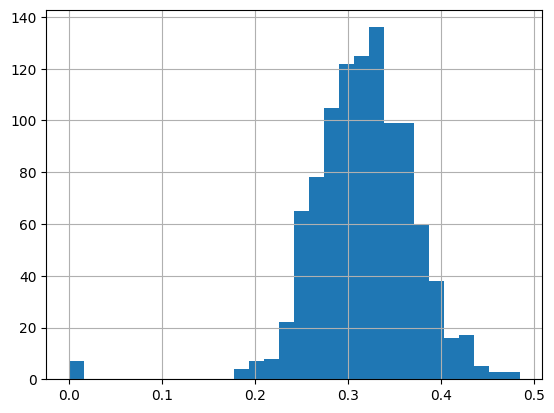

In [18]:
df_tr_basic_correct = correct_coverage_rate(df_tr_basic)
analysis(df_tr_basic_correct)

In [19]:
df_tr_bert = pd.read_csv("prediction_textrank-sum-bert.csv", engine=None)
df_tr_bert = clean_textRank_summary(df_tr_bert)

In [20]:
df_tr_bert = process(df_tr_bert)

average coverage rate is: 0.3038


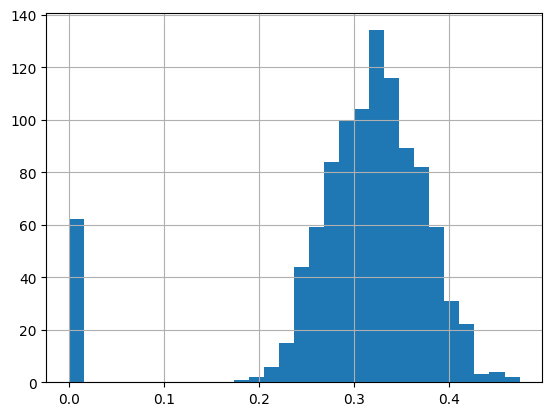

In [21]:
df_tr_bert_correct = correct_coverage_rate(df_tr_bert)
analysis(df_tr_bert_correct)

In [22]:
print(len(df_tr_basic_correct), len(df_tr_bert_correct))

1019 1019


# summary analysis (model generated by other paper)

In [5]:
import pandas as pd
df_mt5_large = pd.read_csv("prediction_mT5-sum-news-ua.csv")
df_mt5_large = process(df_mt5_large)


average coverage rate is: 0.3166


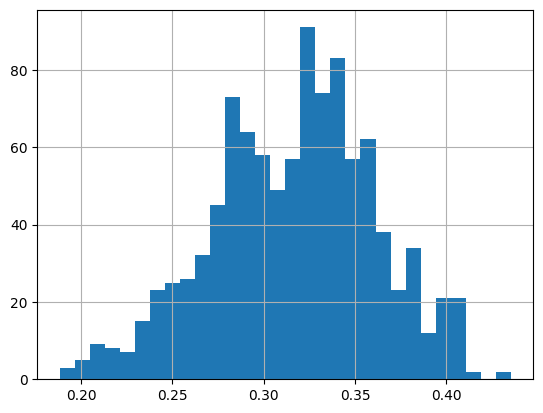

In [8]:
# show distribution
analysis(df_mt5_large)

In [ ]:
df_mt5_large[['summary', 'predicted_class', 'coverage_rate']]

,summary,predicted_class,coverage_rate
0,швейцарський червоний хрест спільно з швейцарс...,Volunteering,0.280093
1,сервіси допомоги мігрантам у канаді підтримуют...,Volunteering,0.402388
2,швейцарія дозволяє самозайнятості в країні зі ...,Integration,0.259173
3,група допомоги швейцарцям у пошуку житла та ро...,Volunteering,0.333447
4,швейцарська влада надала статус захисту s для ...,Volunteering,0.274428
5,genius space відкриває для українців безкоштов...,Education,0.379351
6,у французькому місті сен-преx відкрили бутік д...,Immigration,0.312603
7,у київській обласній дитячій лікарні «академік...,Education,0.236263
8,у швейцарії 11 червня асоціація «українки швей...,Education,0.211033
9,у німецькому місті генєві відкрили художню гру...,Education,0.272107


# summary analysis (mt5-base)

In [9]:
import pandas as pd
df_mt5_base = pd.read_csv("prediction_uk-mt5-base-xlsum-v3.csv")
df_mt5_base = process(df_mt5_base)

average coverage rate is: 0.3216


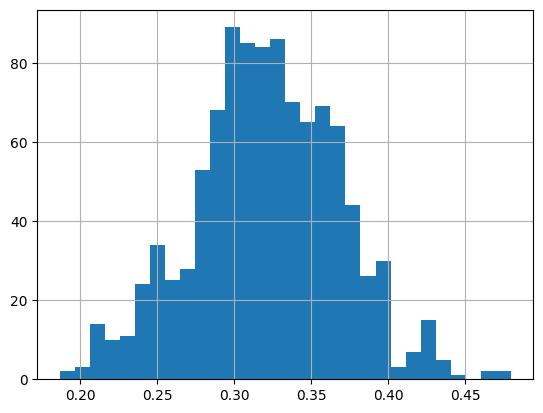

In [10]:
# show distribution
analysis(df_mt5_base)

# ------- draft below-------

In [ ]:
import pandas as pd
df = pd.read_csv("/content/scrape.telegram_forwardsRT30.csv")


In [ ]:
df['tokens'] = df.apply(lambda x: len(x['messageText'].split()), axis=1)
df['tokens'].hist()

In [ ]:
print(len(df))
df_filter = df[df['tokens']>100]
print(len(df_filter))

2636
1019


In [ ]:
df_final = df_filter.drop(columns=['tokens'], axis=1)
list(df_final)

['chat',
 'country',
 'state',
 'city',
 'views',
 'forwards',
 'replies',
 'messageText',
 'predicted_class',
 'messageDate']

In [ ]:
df_final.write_csv("scrape.telegram_forwardsRT30_TokensRT100.csv")

# rouge

In [26]:
pip install rouge_score evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00


In [29]:
import evaluate
rouge = evaluate.load('rouge')

file_list = ["prediction_textrank-sum.csv", "prediction_textrank-sum-bert.csv", "prediction_uk-mt5-base-xlsum-v3.csv"]
reference_summary_list = pd.read_csv("prediction_mT5-sum-news-ua.csv")['summary'].tolist()

for f in file_list:
  predict_summary_list = pd.read_csv(f)['summary'].tolist()
  results = rouge.compute(predictions=predict_summary_list,references=reference_summary_list)
  print(results)



{'rouge1': 0.005076733098431922, 'rouge2': 0.00017842804888928537, 'rougeL': 0.005078480782720605, 'rougeLsum': 0.005080762196531417}
{'rouge1': 0.007803003524298913, 'rouge2': 0.00017842804888928537, 'rougeL': 0.007772706473703324, 'rougeLsum': 0.007859894430319512}
{'rouge1': 0.09189915416608258, 'rouge2': 0.012921164540399084, 'rougeL': 0.09206271321089772, 'rougeLsum': 0.09222860881349598}


In [27]:

predictions = ["the cat was found under the bed, the cat", "was found under the bed"]
references = ["the cat was under the bed", "was found under the bed"]
results = rouge.compute(predictions=predictions,
                       references=references)
results

{'rouge1': 0.9, 'rouge2': 0.8076923076923077, 'rougeL': 0.9, 'rougeLsum': 0.9}

In [28]:
precision =  6/14 # the max numerator is 6
recall = 6/6
print((2*precision*recall)/(precision+recall))

0.6
